Railway Knowledge System
===

Ren Nakagawa

---

## Components
- GPT4o - mini
- ReAct
  - RAG with fasis (鉄道に関する技術上の基準を定める省令)
  - RAG with fasis (鉄道事故報告書)
  - Code Interpleter(Math Calculator)
  - Text Exstractor
  - Search with duckduckgo

In [1]:
IS_ALL_RUN = True

# Set up

In [2]:
!git clone https://github.com/rakawanegan/pbl-railway-knowledge-system
%cd pbl-railway-knowledge-system
%pip uninstall torch torchvision torchaudio -y
%pip install transformers faiss-gpu fugashi ipadic openai langchain langchain-community unidic_lite langchain-openai torch==2.0.1 >> install.txt

Cloning into 'pbl-railway-knowledge-system'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 395 (delta 69), reused 141 (delta 33), pack-reused 218 (from 1)
Receiving objects: 100% (395/395), 6.71 MiB | 6.25 MiB/s, done.
Resolving deltas: 100% (175/175), done.
/content/pbl-railway-knowledge-system
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.

In [3]:
import os
import time
import pandas as pd
from tqdm import tqdm
from contextlib import contextmanager
from google.colab import userdata
from langchain_openai import ChatOpenAI

from src.tool_component import tool_usage_tracker
from src.utils import load_criteria_with_weights
from src.main import make_agent, evaluate_by_llm_with_criteria, plot_tools_count

In [4]:
k = 3
p_tool_configs = [
    "./docs/tools/code.yaml",
    "./docs/tools/incident_rag.yaml",
    "./docs/tools/knowledge_rag.yaml",
    "./docs/tools/raw_text.yaml",
    "./docs/tools/search.yaml",
]
p_eval_configs = [
    "./docs/evals/accuracy.yaml",
    "./docs/evals/calculation.yaml",
    "./docs/evals/evidence.yaml",
    "./docs/evals/expertise.yaml",
    "./docs/evals/expression.yaml",
    "./docs/evals/relevance.yaml",
]
p_react_prompt = "./docs/react_base_prompt.md"

In [5]:
# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
agent = make_agent(p_tool_configs, p_react_prompt, k, llm)
criteria_with_weights = load_criteria_with_weights(p_eval_configs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/content/pbl-railway-knowledge-system/src/main.py:30: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. See LangGraph documentation for more details: https://langchain-ai.github.io/langgraph/. Refer here for its pre-built ReAct agent: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/
  agent = initialize_agent(


In [6]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

def inference(question):
    try:
        output = agent.run(question)
    except Exception as e:
        output = f"Error: {e}"
    return output

# Main

In [7]:
query = """
状況：
あなたは鉄道会社の保守管理責任者です。石勝線での列車脱線事故を受けて、同様の事故を防ぐための点検体制の見直しを任されました。

設問：
省令第87条（施設及び車両の保全）に基づき、減速機の吊りピンについて、どのような点検項目と頻度を設定すべきですか？具体的に3つ以上挙げてください。
点検時に「軽微な摩耗」が見つかった場合、運行継続の判断基準をどのように設定しますか？省令の安全確保の観点から説明してください。
"""

answer = """
点検は3段階で実施することが望ましいです。
まず、毎日の運行前には基本的な日常点検を行います。これには吊りピンの位置確認、ナットの緩みチェック、異音や異常振動の確認が含まれます。
次に、月次の定期点検では、デジタルノギスを使用した吊りピンの摩耗量測定、割りピンの状態確認、ナットの締め付けトルクチェック、そして周辺部品との干渉がないかの確認を行います。
さらに、3ヶ月ごとの精密検査では、非破壊検査による吊りピン内部の亀裂検査、溝付き六角ナットの詳細な摩耗状態検査、減速機取付部全体の応力測定を実施します。
"""

In [8]:
with timer("inference"):
    predict = inference(query)

<ipython-input-6-f61884859005>:9: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = agent.run(question)




> Entering new AgentExecutor chain...
この質問に対処するためには、まず省令第87条に関連する内容を確認し、減速機の吊りピンに関する点検項目とその頻度を特定する必要があります。また、軽微な摩耗が見つかった場合の運行継続の判断基準についても考慮する必要があります。

Action: RailwayTechnicalStandardSearcher  
Action Input: 「省令第87条 減速機 吊りピン」  

Observation: 構造物及び軌道の保全については、「鉄道構造物等維持管理標準の制定について」（平成19年1月16日付け国鉄技第73号）の通達によること。 鋼索鉄道の索条の交換は、別紙第５の「鋼索鉄道の索条交換基準について」によること。 第１項ただし書中「施設及び車両の構造等により、当該係員を乗務させなくても列車の安全な運転に支障がない場合」は、次の各号を満たす場合であり、かつ、第３６条第３号、第５８条、第８６条第２項に規定する基準に適合するものであること。
Thought:この情報は省令第87条に関連する具体的な内容を提供していないため、次に進む必要があります。減速機の吊りピンに関する点検項目と頻度を特定するために、より具体的な情報を探す必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「減速機 吊りピン 点検」  

Observation: 
Thought:この情報は省令第87条に関連する具体的な内容を提供していないため、次に進む必要があります。減速機の吊りピンに関する点検項目と頻度を特定するために、より具体的な情報を探す必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「減速機 吊りピン」  

Observation: 
Thought:この情報は省令第87条に関連する具体的な内容を提供していないため、次に進む必要があります。減速機の吊りピンに関する点検項目と頻度を特定するために、より具体的な情報を探す必要があります。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「

In [9]:
print(predict)

省令第87条に基づく減速機の吊りピンに関する点検項目と頻度は以下の通りです。

1. **点検項目**:
   - 吊りピンの摩耗状態の確認
   - 吊りピンの取り付け状態（緩みや異常の有無）
   - 吊りピン周辺の腐食や損傷の確認

2. **点検頻度**:
   - 定期点検: 毎月1回
   - 臨時点検: 異常が発生した場合や運行条件が変わった場合に実施
   - 年次総合点検: 年に1回、全体的な状態を確認するための詳細な点検

軽微な摩耗が見つかった場合の運行継続の判断基準は以下のように設定します。

- **運行継続の判断基準**:
  - 摩耗の程度が設計基準の許容範囲内であることを確認する。
  - 摩耗が進行する可能性が低いと判断される場合、運行を継続する。
  - 定期的な監視を行い、摩耗の進行状況を記録し、次回の点検で再評価する。

これにより、安全確保の観点から、軽微な摩耗があっても運行を続けることができるが、常に監視を行い、必要に応じて早期に対策を講じることが重要です。


In [10]:
dict_eval = evaluate_by_llm_with_criteria(
    predict,
    answer,
    llm,
    question=query,
    criteria_with_weights=criteria_with_weights,
)

/content/pbl-railway-knowledge-system/src/main.py:99: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)


1. 情報の読み込み:     - 解答には「点検項目」として「吊りピンの摩耗状態の確認」「取り付け状態の確認」「腐食や損傷の確認」が挙げられている。     - 点検頻度として「定期点検: 毎月1回」「臨時点検: 異常時」「年次総合点検: 年に1回」が記載されている。     - 軽微な摩耗の運行継続判断基準についても「設計基準の許容範囲内」「摩耗進行の可能性が低い」「定期的な監視」が述べられている。  2. 情報の比較:     - 採点対象には「日常点検」「月次の定期点検」「3ヶ月ごとの精密検査」が記載されており、点検項目も具体的に挙げられている。     - ただし、解答に比べて「軽微な摩耗」の運行継続判断基準に関する具体的な基準が不足している。  3. 不足情報のリストアップ:     - 不足情報: 軽微な摩耗の運行継続判断基準に関する具体的な基準が不明確である。     - 採点対象には「設計基準の許容範囲内であることを確認する」などの具体的な基準が記載されていない。  4. 評価値の算出:     - 重要な情報の一部が欠けているため、評価は「3点」とする。  - 評価結果: 【3】点    - 理由: 軽微な摩耗の運行継続判断基準に関する具体的な基準が不足しているが、他の情報は概ね正確に記載されている。
【N/A】点  理由: 問題には計算が含まれていないため、評価対象外とする。
【5】点  理由: 採点対象は問題に関連する根拠を具体的に提示しており、減速機の吊りピンに関する点検項目と頻度を明確に示しています。また、軽微な摩耗に関する運行継続の判断基準も省令の安全確保の観点から適切に説明されており、信頼性が高いです。問題に関係のない情報は含まれていません。
評価結果: 【4】点  理由: 専門用語の使用は概ね正確であり、特に「吊りピン」「摩耗」「点検」などの用語は適切に使用されている。しかし、「軽微な摩耗」の運行継続の判断基準に関して、具体的な基準値や許容範囲の明示が不足しており、文脈の一部が不明確であるため、若干の減点とした。
【4】点  理由: 解答は全体的に論理的で要点が整理されているが、一部の表現がやや冗長であり、簡潔さに欠ける部分が見受けられる。特に、点検項目や頻度の説明がもう少し簡潔にまとめられると、さらに読みやすくなる。
1. **役

In [11]:
for k, v in dict_eval.items():
    print(f'{k} {v}')
    print()

VeritasSentinel 3.0

ArithmeticGuardian N/A

EvidenceEvaluator 5.0

TerminologyInspector 4.0

ClarityReviewer 4.0

RequirementAdherenceChecker 5.0

final_feedback 1. 情報の読み込み:  
   - 解答には「点検項目」として「吊りピンの摩耗状態の確認」「取り付け状態の確認」「腐食や損傷の確認」が挙げられている。  
   - 点検頻度として「定期点検: 毎月1回」「臨時点検: 異常時」「年次総合点検: 年に1回」が記載されている。  
   - 軽微な摩耗の運行継続判断基準についても「設計基準の許容範囲内」「摩耗進行の可能性が低い」「定期的な監視」が述べられている。  
2. 情報の比較:  
   - 採点対象には「日常点検」「月次の定期点検」「3ヶ月ごとの精密検査」が記載されており、点検項目も具体的に挙げられている。  
   - ただし、解答に比べて「軽微な摩耗」の運行継続判断基準に関する具体的な基準が不足している。  
3. 不足情報のリストアップ:  
   - 不足情報: 軽微な摩耗の運行継続判断基準に関する具体的な基準が不明確である。  
   - 採点対象には「設計基準の許容範囲内であることを確認する」などの具体的な基準が記載されていない。  
4. 評価値の算出:  
   - 重要な情報の一部が欠けているため、評価は「3点」とする。  
- 評価結果: 【3】点  
  - 理由: 軽微な摩耗の運行継続判断基準に関する具体的な基準が不足しているが、他の情報は概ね正確に記載されている。
【N/A】点  
理由: 問題には計算が含まれていないため、評価対象外とする。
【5】点  
理由: 採点対象は問題に関連する根拠を具体的に提示しており、減速機の吊りピンに関する点検項目と頻度を明確に示しています。また、軽微な摩耗に関する運行継続の判断基準も省令の安全確保の観点から適切に説明されており、信頼性が高いです。問題に関係のない情報は含まれていません。
評価結果: 【4】点  
理由: 専門用語の使用は概ね正確であり、特に「吊りピン」「摩耗」「点検」などの用語は適切に使用されている。しかし、「軽

In [12]:
df = pd.read_csv("data/Question.csv")
df.head()

,参照,種類,問題,答え,解説
0,01.md,穴埋め問題,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄...,実施基準,実施基準は、鉄道事業者が各自の特性や状況に応じて具体的な運行や管理の方法を定めるための重要な...
1,01.md,穴埋め問題,実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や_...,理論解析,理論解析は、実績やデータに基づいて検討を行うことで、より正確な適合性を確認できる手法です。こ...
2,01.md,穴埋め問題,新幹線の騒音については、新幹線鉄道に係る環境基準によるものとするが、音源対策が_____の防...,騒音,騒音は住環境に大きな影響を与えるため、その対策は非常に重要です。特に新幹線のような高速鉄道で...
3,01.md,抽象問題,鉄道事業者が策定する実施基準の内容には、どのような要素が含まれるべきか、具体的に説明してください。,実施基準には、解釈基準により示された例示、設計方法、検証方法等が含まれ、数値化された具体的な...,実施基準は、鉄道の安全性や効率性を確保するために必要不可欠です。特に数値化された基準は、実際...
4,01.md,抽象問題,新幹線に関する騒音の環境基準はどのように設定されているか、具体的に説明してください。,新幹線の騒音は、環境省の基準に基づき、音源対策により沿線の住宅の集合度合いに応じて75デシベ...,騒音基準は、周辺住民の生活環境を守るために重要です。特に新幹線のように高速度で走行する鉄道で...


In [13]:
df_answer = list()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if not IS_ALL_RUN:
        break
    row = dict(row)
    query = row["問題"]
    answer = row["答え"]
    predict = inference(query)
    dict_eval = evaluate_by_llm_with_criteria(
        pred=predict, answer=answer,
        llm=llm, criteria_with_weights=criteria_with_weights
    )
    print(dict_eval)
    dict_eval.update({
        "answer": predict,
    })
    row.update(dict_eval)
    df_answer.append(row)
df_answer = pd.DataFrame(df_answer)
df_answer.to_csv("data/Answer.csv", index=False)

  0%|          | 0/30 [00:00<?, ?it/s]



> Entering new AgentExecutor chain...
Question: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な_____を策定することとする。
Thought: この文は鉄道事業者が省令に基づいて策定する必要がある文書や計画についてのもので、空欄に入る適切な用語を探す必要があります。鉄道に関連する技術基準や計画に関する情報を検索するのが良いでしょう。
Action: RailwayTechnicalKeywordSearcher
Action Input: 「鉄道事業者 設計 維持管理 運行」
Observation: 鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
実施基準の項目は、省令等の項目に対応したものとし、内容は、解釈基準により示された例示、設計方法、検証方法等に準じて、数値化する等具体的に示すこととする。
実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
- 事故、自然災害、大みそか等通常と異なる運行をする場合
「施設及び車両の保守その他これに類する作業を行う係員」は、次のとおりとし、鉄道事業者が「施設及び車両の保守その他これに類する作業」を委託する場合にあっては、委託した作業を行う鉄道事業者に所属する係員以外の係員を含むものとすること。
１の係員に対する教育及び訓練の実施、適性、知識及び技能の確認は、当該係員の所属する鉄道事業者（係員が所属している事業者が鉄道事業者以外の場合にあっては、当該作業を委託した鉄道事業者。以下同じ。）が実施要領を定めて行うこととする。ただし、教育及び訓練の実施、適性、知識及び技能の確認の管理を当該鉄道事業者が行う場合は、他の者にこれを行わせることができる。
仕業前後に対面（運行上やむを得ない場合は電話その他の方法。）により、酒気帯びの有無を確認すること。
酒気帯びの有無の確認は、目視等によるほ

  3%|▎         | 1/30 [00:42<20:24, 42.21s/it]

1. 問題の要求の特定:     - 問題文は「詳細な実施基準を策定すること」と述べており、具体的な用語「実施基準」を求めている。2. 採点対象の確認:     - 採点対象は「実施基準」と明確に示されており、問題文の要求に対して適切に応じている。3. 不足や誤りの確認:     - 採点対象は問題文の要求を正確に満たしており、特に不足や誤りは見受けられない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。
{'VeritasSentinel': 5.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 5.0, 'final_feedback': '評価プロセス:  \n1. 情報の読み込み:  \n   - 解答：「鉄道事業者」「施設」「車両の設計」「維持管理」「運行」「省令の範囲内」「個々の鉄道事業者の実状」「詳細な実施基準」  \n   - 採点対象：「鉄道事業者」「施設」「車両の設計」「維持管理」「運行」「省令の範囲内」「個々の鉄道事業者の実状」「詳細な実施基準」  \n2. 情報の比較:  \n   - 解答に記載されている情報は、採点対象にも全て含まれている。過不足はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: なし  \n4. 評価値の算出:  \n   - 重要な情報が全て記載されており、誤りもないため、評価は「5点」とする。  \n評価結果: 【5】点  \n理由: 重要な情報が全て記載されており、誤りが一切ないため。\n評価対象には計算が含まれていないため、本項目は評価対象外（N/A）とします。  \n評価結果: N/A\n【5】点  \n理由: 採点対象の「実施基準」は、問題文における「詳細な実施基準を策定すること」という部分に直接関連しており、具体的かつ信頼性の高い根拠を提示している。問題に関係のない情報は含まれておらず、明確に問題の意図を反映しているため

  7%|▋         | 2/30 [01:35<22:39, 48.56s/it]

1. 問題の要求の特定:     - 問題文は「解釈基準」に関する内容を求めており、具体的には技術基準に関連する文書を参照する必要があることを示唆している。2. 採点対象の確認:     - 解答は「理論解析」となっているが、問題文の要求に対して具体的な内容や要約が示されていない。3. 不足や誤りの確認:     - 解答は問題文の要求に対して全く関連性がなく、内容が不適切であるため、大きく逸脱していると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 1.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 3.0, 'RequirementAdherenceChecker': 1.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「この解釈基準は、技術的実績や実証データに基づく確認方法を用いて、鉄道事業者が省令への適合を証明することを認めており、これにより本解釈基準に従わない構造等も許可されることを示しています。具体的な内容については、技術基準に関連する文書を参照する必要があります。」  \n   - 採点対象：「理論解析」  \n2. 情報の比較:  \n   - 解答に記載されている重要な情報（解釈基準、技術的実績、実証データ、鉄道事業者、省令への適合、許可される構造、技術基準に関連する文書の参照）が採点対象には全く記載されていない（全て不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「解釈基準」「技術的実績」「実証データ」「鉄道事業者」「省令への適合」「許可される構造」「技術基準に関連する文書の参照」  \n4. 評価値の算出:  \n   - 重要な情報がほとんど記載されておらず、誤りも含まれていないため、評価は「1点」とする。  \n- 評価結果: 【1】点

 10%|█         | 3/30 [02:24<21:58, 48.83s/it]

1. 問題の要求の特定:     - 問題文は「新幹線の騒音についての内容を要約する」ことを求めている。2. 採点対象の確認:     - 採点対象は「騒音」という単語のみであり、具体的な内容や要約が示されていない。3. 不足や誤りの確認:     - 要約としては非常に不十分であり、問題文の要求をほとんど満たしていない。具体的な情報や要約が欠けているため、内容が不適切と判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が大幅に逸脱しているため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 1.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「新幹線の騒音」「環境基準」「音源対策」「75デシベル以下」  \n   - 採点対象：「騒音」  \n2. 情報の比較:  \n   - 解答に記載されている「新幹線の騒音」「環境基準」「音源対策」「75デシベル以下」が採点対象には記載されていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「新幹線の騒音」「環境基準」「音源対策」「75デシベル以下」  \n4. 評価値の算出:  \n   - 重要な情報がほとんど欠けているため、評価は「1点」とする。  \n- 評価結果: 【1】点  \n  - 理由: 重要な情報がほとんど記載されておらず、誤りはないが情報が非常に不足している。\n評価プロセス:  \n1. 情報の読み込み:  \n   - 解答: "騒音"  \n   - 採点対象: "新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものであり、音源対策が騒音の防止または軽減を図る上で最も基本的な施策です。環境省からの要請に

 13%|█▎        | 4/30 [03:19<22:10, 51.19s/it]

1. 問題の要求の特定:     - 実施基準に含まれるべき要素を挙げることが求められている。2. 採点対象の確認:     - 採点対象は「実施基準には、解釈基準により示された例示、設計方法、検証方法等が含まれ、数値化された具体的な内容が求められる。」という内容で、実施基準の要素を示している。3. 不足や誤りの確認:     - 採点対象は実施基準の要素を挙げているが、具体的な要素（技術基準、運行管理、保守点検、安全対策、巡視基準など）が欠けているため、問題文の要求を完全には満たしていない。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、具体的な要素が不足しているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答には「技術基準」「運行管理」「保守点検」「安全対策」「巡視基準」が含まれている。  \n   - 採点対象には「解釈基準により示された例示、設計方法、検証方法等が含まれ、数値化された具体的な内容が求められる」と記載されている。\n2. 情報の比較:  \n   - 解答に記載されている「技術基準」「運行管理」「保守点検」「安全対策」「巡視基準」が採点対象には記載されていない（不足情報）。  \n   - 採点対象には過剰情報はない。\n3. 不足情報のリストアップ:  \n   - 不足情報: 「技術基準」「運行管理」「保守点検」「安全対策」「巡視基準」\n4. 評価値の算出:  \n   - 重要な情報がほとんど欠けているため、評価は「1点」とする。\n- 評価結果: 【1】点  \n  - 理由: 重要な情報がほとんど記載されておらず、誤りが非常に多い。\n評価対象には計算が含まれていないため、本項目は評価対象外（N/A）とします。\n【4】点  \n理由: 採点

 17%|█▋        | 5/30 [03:38<16:32, 39.71s/it]

1. 問題の要求の特定:     - 問題文は新幹線に関する騒音の環境基準についての要約を求めている。2. 採点対象の確認:     - 採点対象は新幹線の騒音基準についての要約を行っており、環境省の基準に基づく内容が含まれている。3. 不足や誤りの確認:     - 採点対象は騒音基準の目標（75デシベル以下）を正確に述べているが、測定方法や昼間・夜間の基準（60デシベル、55デシベル）については触れていないため、情報が不完全である。4. 評価値の算出:     - 問題文の要求を概ね満たしているが、重要な情報が欠けているため「4点」とする。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な不足がある）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 4.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「新幹線」「騒音」「環境省の基準」「音源対策」「沿線の住宅の集合度合い」「75デシベル以下」  \n2. 情報の比較:  \n   - 採点対象には「新幹線に関する騒音の環境基準」「測定方法」「新設の普通鉄道の基準」などの重要な情報が含まれていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「新幹線に関する騒音の環境基準」「測定方法」「新設の普通鉄道の基準」  \n4. 評価値の算出:  \n   - 重要な情報の多くが欠けているため、評価は「2点」とする。  \n- 評価結果: 【2】点  \n  - 理由: 重要な情報の多くが不足しているが、誤りや過剰情報はない。\n評価結果: N/A  \n理由: 採点対象には計算が含まれていないため、評価対象外とします。\n【4】点  \n理由: 採点対象は新幹線の騒音に関する環境基準について言及しており、問題文の内容に関連しています。ただし、具体的な測定方法や新設の普通鉄道の基準についての詳細が欠

 20%|██        | 6/30 [04:08<14:32, 36.34s/it]

1. 問題の要求の特定:     - 問題文は「普通鉄道の新設または大規模改良における騒音レベルの基準」についての情報を求めている。2. 採点対象の確認:     - 採点対象は「新設の場合、昼間は60デシベル以下、夜間は55デシベル以下とし、大規模改良は改良前より騒音レベルを改善することが求められる。」という内容である。3. 不足や誤りの確認:     - 採点対象は新設の騒音基準について具体的な数値を示しているが、問題文に記載されている「75デシベル以下」という目標や、音源対策の必要性については触れられていない。また、大規模改良に関しても「改良前より改善することが求められる」という点は正しいが、具体的な数値や基準が不足している。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な情報が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 3.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「新設の場合、昼間は60デシベル以下、夜間は55デシベル以下とし、大規模改良は改良前より騒音レベルを改善することが求められる。」  \n   - 採点対象：「普通鉄道の新設または大規模改良における騒音レベルの基準は、新幹線鉄道に係る環境基準に基づき、音源対策を講じることが求められ、沿線の住宅の集合度合いに応じて、騒音レベルを75デシベル以下にすることを目標としています。また、大規模改良では、騒音レベルの状況を改良前より改善することが求められています。」  \n2. 情報の比較:  \n   - 採点対象には「新設の場合、昼間は60デシベル以下、夜間は55デシベル以下」という具体的な数値が記載されているが、採点対象には「音源対策」や「沿線の住宅の集合度合いに応じて、騒音レベルを75デシベル以下にすることが目標」という重要な情報が欠け

 23%|██▎       | 7/30 [04:42<13:35, 35.47s/it]

【0】点（データが見つからなかったという文言が含まれており、問題文の要求を満たしていないため）
{'VeritasSentinel': 0.0, 'ArithmeticGuardian': 0.0, 'EvidenceEvaluator': 0.0, 'TerminologyInspector': 0.0, 'ClarityReviewer': 0.0, 'RequirementAdherenceChecker': 0.0, 'final_feedback': '【0】点  \n理由: 採点対象は「係員」と記載されているが、解答には「運転士」や「運転操作」などの具体的な情報が含まれており、関連する技術基準を見つけられなかったという文言が含まれているため、重要な情報が欠けており、誤りがある。\n【0】点  \n理由: 採点対象には計算が含まれておらず、また「関連する技術基準を見つけることができませんでした」という文言が含まれているため、評価基準に従いスコアは0点とする。\n【0】点  \n理由: 採点対象は「申し訳ありませんが、関連する技術基準を見つけることができませんでした」と明記しており、根拠が見つからなかったことを示しています。このため、問題に関連する具体的かつ信頼性の高い情報が提示されておらず、評価基準を満たしていません。\n【0】点  \n理由: 採点対象の解答には「申し訳ありませんが、関連する技術基準を見つけることができませんでした」という文言が含まれており、これはデータが見つからなかったことを示しています。このため、専門用語の使用や文脈との整合性を評価することができず、スコアは0点となります。\n【0】点  \n理由: 採点対象には「関連する技術基準を見つけることができませんでした」というエラー文が含まれており、情報が提供されていないため、論理性や簡潔さが評価できない。\n【0】点（データが見つからなかったという文言が含まれており、問題文の要求を満たしていないため）', 'final_score': 0.0}


> Entering new AgentExecutor chain...
この質問は、鉄道に関する技術基準や省令に関連する内容のようです。具体的には、施設や車両の保守作業に関する係員の定義や委託に関する規定を探す必要があります。したがって、鉄

 27%|██▋       | 8/30 [05:02<11:16, 30.77s/it]

【3】点（問題文の要求を部分的に満たしているが不十分）
{'VeritasSentinel': 3.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '【3】点  \n理由: 解答には「作業」という重要な情報が含まれているが、採点対象の内容に対して「施設及び車両の保守その他これに類する作業を行う係員」や「教育及び訓練の実施」などの重要な情報が不足しているため、評価は「3点」とする。誤りや過剰情報はない。\n評価結果: N/A  \n理由: 問題文には計算が含まれておらず、したがって評価対象外であるため。\n【4】点  \n理由: 採点対象は「施設及び車両の保守その他これに類する作業」に関連する係員の役割について言及しており、問題文の内容に関連しています。ただし、「作業」という単語だけでは具体性に欠けるため、もう少し詳細な説明があれば5点に近づくと考えられます。\n【4】点  \n理由: 専門用語「作業」は文脈において適切に使用されているが、具体的な内容や範囲が不明確であり、文脈との整合性がやや欠けているため、完全な正確性には至っていない。\n【4】点  \n理由: 採点対象は全体的に論理的で要点が整理されているが、一部表現がやや冗長で、もう少し簡潔にまとめることができる部分があるため、4点と評価した。\n【3】点（問題文の要求を部分的に満たしているが不十分）', 'final_score': 3.0}


> Entering new AgentExecutor chain...
この文は鉄道に関する技術基準の一部のようです。具体的な技術基準や関連する内容を探すために、キーワードを使って検索する必要があります。ここでは「第３項の知識及び技能」や「係員に対する確認」というフレーズを基に関連情報を探します。

Action: RailwayTechnicalKeywordSearcher  
Action Input: 「第３項の知識 係員 確認」  
Observation: 実施基準は、本解

 30%|███       | 9/30 [05:21<09:24, 26.88s/it]

1. 問題の要求の特定:     - 問題文は、特定の手順に従って「酒気を帯びた状態」の確認方法を求めている。2. 採点対象の確認:     - 採点対象は「酒気を帯びた状態」とのみ記載されており、具体的な確認手順や方法についての詳細が欠けている。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して非常に不十分であり、確認手順や方法が全く示されていないため、大きく逸脱していると判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切または大幅に逸脱している）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 1.0, 'final_feedback': '評価結果: 【2】点  \n理由: 採点対象は「酒気を帯びた状態」という表現のみであり、解答に含まれる重要な情報（確認方法や手順、記録の必要性など）がほとんど記載されていない。重要な情報の多くが不足しているため、評価は低くなった。誤りや過剰情報はない。\n評価対象には計算が含まれていないため、本項目は評価対象外（N/A）とします。  \n【N/A】\n【4】点  \n理由: 採点対象は「酒気を帯びた状態」という解答を提示しており、これは問題文の「特に regarding sobriety」に関連している。しかし、具体的な確認方法や手順についての詳細が不足しているため、具体性に欠ける部分がある。全体的には問題に関連しているが、もう少し具体的な情報があれば5点に近づく。\n評価結果: 【4】点  \n理由: 専門用語「酒気を帯びた状態」は正確に使用されているが、文脈との整合性がやや不明確であり、具体的な確認プロセスに関する詳細が不足しているため、若干の減点となった。\n【4】点  \n理由: 採点対象は全体的に論理的で要点が整理されているが、一部の表現がやや冗長であり、簡潔さに欠

 33%|███▎      | 10/30 [05:47<08:57, 26.89s/it]

1. 問題の要求の特定:     - 問題文は「適性の確認」に関する内容を求めており、具体的には「身体機能検査及び精神機能検査」という解答が求められている。2. 採点対象の確認:     - 採点対象は「身体機能検査及び精神機能検査」となっており、適性確認の具体的な方法を示している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して適切な内容を示しているが、具体的な実施要領や酒気帯びの確認についての言及がないため、完全ではない。4. 評価値の算出:     - 問題文の要求を概ね満たしているが、軽微な不足があるため「4点」とする。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な不足がある）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 3.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 4.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「身体機能検査」「精神機能検査」  \n   - 採点対象：「適性の確認」「教育及び訓練の実施」「知識及び技能の確認」「酒気を帯びた状態の確認」  \n2. 情報の比較:  \n   - 解答に記載されている「身体機能検査」「精神機能検査」は、採点対象の「適性の確認」に関連する情報ではあるが、具体的な内容が不足している。  \n   - 採点対象には「教育及び訓練の実施」「知識及び技能の確認」「酒気を帯びた状態の確認」といった重要な情報が含まれているが、解答にはこれらが含まれていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「適性の確認」「教育及び訓練の実施」「知識及び技能の確認」「酒気を帯びた状態の確認」  \n4. 評価値の算出:  \n   - 重要な情報がほとんど記載されておらず、誤りはないが、情報が非常に不足しているため、評価は「1点」とする。  \n- 評価結果: 【1】点  \n  - 理由: 重要な情報がほとんど記載さ

 37%|███▋      | 11/30 [06:13<08:23, 26.50s/it]

1. 問題の要求の特定:     - 問題文は「第11条で規定されている内容」に基づいて、当該係員を乗務させなくても列車の安全な運転に支障がない場合の基準を求めている。2. 採点対象の確認:     - 採点対象は「人等が容易に線路内に立ち入ることができない構造であり、列車の進路を支障する事態が発生するおそれがない」と述べている。3. 不足や誤りの確認:     - 採点対象は、問題文の要求に対して「列車の安全な運転に支障がない基準」を示しているが、具体的な基準や条件についての詳細が不足している。また、教育や訓練の実施、適性、知識及び技能の確認についての言及がないため、全体的に不十分である。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な要素が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 2.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「当該係員を乗務させなくても列車の安全な運転に支障がない場合」「施設及び車両の構造等」「教育及び訓練の実施」「適性、知識及び技能の確認」  \n   - 採点対象：「人等が容易に線路内に立ち入ることができない構造」「列車の進路を支障する事態が発生するおそれがない」  \n2. 情報の比較:  \n   - 解答に記載されている「当該係員を乗務させなくても列車の安全な運転に支障がない場合」や「教育及び訓練の実施」などの重要な情報が採点対象には含まれていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「当該係員を乗務させなくても列車の安全な運転に支障がない場合」「施設及び車両の構造等」「教育及び訓練の実施」「適性、知識及び技能の確認」  \n4. 評価値の算出:  \n   - 重要な情報の多

 40%|████      | 12/30 [06:39<07:52, 26.26s/it]

1. 問題の要求の特定:     - 問題文は「酒気を帯びた状態又は薬物の影響により正常な操縦ができないおそれがある状態」を抜き出すことを求めている。2. 採点対象の確認:     - 採点対象は「酒気を帯びた状態又は薬物の影響により正常な操縦ができないおそれがある状態」となっており、問題文の要求に対して正確に該当箇所を抜き出している。3. 不足や誤りの確認:     - 採点対象は問題文の要求を完全に満たしており、内容も適切で正確であるため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。
{'VeritasSentinel': 5.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 5.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「酒気を帯びた状態」「薬物の影響」「正常な操縦ができないおそれがある状態」  \n   - 採点対象：「酒気を帯びた状態又は薬物の影響により正常な操縦ができないおそれがある状態」  \n2. 情報の比較:  \n   - 採点対象は解答に含まれる全ての重要な情報を含んでおり、特に「酒気を帯びた状態」と「薬物の影響」が明確に記載されている。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: なし  \n4. 評価値の算出:  \n   - 重要な情報が全て記載されており、誤りもないため、評価は「5点」とする。  \n- 評価結果: 【5】点  \n  - 理由: 重要な情報が全て記載されており、誤りが一切ない。\nN/A  \n理由: 問題には計算が含まれておらず、したがって評価対象外であるため。\n評価プロセス:\n1. 情報の読み込み:\n   - 問題文：「動力車を操縦する係員は、酒気を帯びた状態や薬物の影響により正常な操縦ができないおそれがあ

 43%|████▎     | 13/30 [06:53<06:24, 22.62s/it]

1. 問題の要求の特定:     - 問題文は「旅客の取扱いに必要な駅設備」を挙げることを求めている。2. 採点対象の確認:     - 採点対象は「プラットホ－ム」となっている。3. 不足や誤りの確認:     - 「プラットホ－ム」は駅設備の一部ではあるが、問題文で求められているのは「旅客の取扱いに必要な駅設備」の全体であり、他の設備（流動設備、接客設備、滞留設備、業務施設、便所、照明設備など）も含める必要がある。したがって、採点対象は不十分である。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、他の重要な設備が挙げられていないため「2点」とする。- 評価結果:    - 【2】点（問題文の要求に大きく逸脱しており、不足や誤りが多い）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 2.0, 'final_feedback': '評価結果: 【2】点  \n理由: 採点対象には「プラットホーム」のみが記載されており、他の重要な情報（流動設備、接客設備、滞留設備、業務施設、便所、照明設備など）が欠けているため、重要な情報の多くが不足している。また、誤りはないが、情報が非常に限られている。\n【N/A】点  \n理由: 問題には計算が含まれておらず、したがって評価対象外である。\n【4】点  \n理由: 採点対象の「プラットホ－ム」は、問題文に記載されている「駅設備」の一部として直接関連しており、信頼性が高い。しかし、具体的な説明や他の設備との関連性が欠けているため、完全な具体性には至っていない。\n評価結果: 【5】点  \n理由: 専門用語「プラットホーム」は、問題文における「駅設備」の一部として正確に使用されており、文脈との整合性も完全であるため、評価は最高点となる。\n【4】点  \n理由: 採点対象は要点が明確に整理されており、論理的な構成が保たれている。ただし、「プラットホ－ム」という単語のみの記述はやや不十分で、他の駅設備に関する情報が欠けているため、

 47%|████▋     | 14/30 [07:04<05:06, 19.15s/it]

1. 問題の要求の特定:     - 問題文は「プラットホームの幅」に関する具体的な数値を求めている。2. 採点対象の確認:     - 採点対象は「3m」となっており、問題文に記載されている「中央部を3m以上」と一致している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して正確であり、必要な情報を適切に抜き出している。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。
{'VeritasSentinel': 5.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 5.0, 'final_feedback': '評価結果: 【5】点  \n理由: 解答には「3m」という重要な情報が正確に記載されており、採点対象に誤りや不足は一切ないため、評価は最高点となる。\n【N/A】点  \n理由: 問題には計算が含まれておらず、解答も単純な数値の提示であるため、評価対象外とする。\n【5】点  \n理由: 採点対象は問題文の内容に直接関連しており、具体的に「3m」という数値を正確に引用しているため、信頼性が非常に高い。問題に関係のない情報は含まれておらず、根拠が明確である。\n【5】点  \n理由: 専門用語「プラットホーム」「幅」「普通鉄道」「特殊鉄道」が正確に使用されており、文脈との整合性も完全である。解答の「3m」も問題文の内容に基づいており、誤解を生むことはない。\n【4】点  \n理由: 採点対象は要点が明確に整理されており、論理的な構成が保たれている。ただし、表現がやや冗長であるため、簡潔さに欠ける部分が見受けられる。\n1. 問題の要求の特定:  \n   - 問題文は「プラットホームの幅」に関する具体的な数値を求めている。\n2. 採点対象の確認:  \n   - 採点対象は「3m」となっており、問題文に記載されている「中央部を3m以上」と一致している。\n3

 50%|█████     | 15/30 [07:36<05:42, 22.83s/it]

1. 問題の要求の特定:     - 問題文は「プラットホームにある柱類とプラットホームの縁端との距離は1.2m以上とする。」という内容に基づいて、適切な距離を示すことを求めている。2. 採点対象の確認:     - 採点対象は「2m」となっており、これは1.2m以上という条件を満たしている。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して適切な距離を示しているが、具体的な理由や説明が欠けているため、完全な回答とは言えない。4. 評価値の算出:     - 問題文の要求を概ね満たしているが、軽微な不足があるため「4点」とする。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な不足がある）。
{'VeritasSentinel': 3.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 2.0, 'TerminologyInspector': 2.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 4.0, 'final_feedback': '評価プロセス:  \n1. 情報の読み込み:  \n   - 解答：「プラットホームにある柱類とプラットホームの縁端との距離は1.2m以上とする。」  \n   - 採点対象：「2m」  \n2. 情報の比較:  \n   - 解答に記載されている「1.2m以上」という基準が採点対象には記載されていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「1.2m以上」  \n4. 評価値の算出:  \n   - 重要な情報の一部が欠けているため、評価は「3点」とする。  \n評価結果: 【3】点  \n理由: 「1.2m以上」という基準が不足しているが、誤りや過剰情報はない。\n評価プロセス:  \n1. 情報の読み込み:  \n   - 解答：「プラットホームにある柱類とプラットホームの縁端との距離は1.2m以上とする。」  \n   - 採点対象：「2m」  \n2. 計算箇所の特定:  \n   - 採点対象には計算過程が含まれていないため、計算を含む評価は行わない。  \n3. 結

 53%|█████▎    | 16/30 [08:02<05:36, 24.03s/it]

1. 問題の要求の特定:     - 問題文は「プラットホームの有効長に関する基準」についての内容を求めている。2. 採点対象の確認:     - 採点対象は「プラットホームの有効長は、旅客が安全に乗降できるようにするために設定されており、列車の運行状況に応じて調整されることが重要である。」という内容である。3. 不足や誤りの確認:     - 採点対象はプラットホームの有効長の目的や重要性について言及しているが、問題文の要求に対しては「事故のリスクを低減し、快適な移動環境を提供すること」という具体的な目的が不足している。また、列車の運行状況に応じた調整についても、問題文の内容に対する具体的な関連性が薄い。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な要素が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 3.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「プラットホームの有効長」「旅客が安全に乗降」「列車の運行状況に応じて調整」  \n   - 採点対象：「プラットホームの有効長」「旅客の安全と円滑な乗降」「適切なスペース」「事故のリスクを低減」「快適な移動環境を提供」  \n2. 情報の比較:  \n   - 採点対象には解答に含まれる「旅客が安全に乗降できるようにするために設定されている」という情報が含まれているが、解答の「列車の運行状況に応じて調整されることが重要である」という部分は採点対象には記載されていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「列車の運行状況に応じて調整されることが重要である」  \n4. 評価値の算出:  \n   - 重要な情報の一部が欠けているため、評価は「3点」とする。  \n評価

 57%|█████▋    | 17/30 [08:25<05:07, 23.67s/it]

1. 問題の要求の特定:     - 問題文は新幹線のプラットホームの幅に関する基準を求めている。2. 採点対象の確認:     - 解答は「9m」となっており、両側使用の場合の幅の基準を正確に示している。3. 不足や誤りの確認:     - 解答は片側使用の場合の基準（5m）を含んでおらず、全体の基準を示すには不十分である。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な情報が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 5.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「新幹線のプラットホームの幅に関する基準は、旅客の安全、円滑な乗降、アクセシビリティ、緊急時の避難、運行効率において重要です。両側使用の場合は幅が9m以上、片側使用の場合は5m以上と定められています。」  \n   - 採点対象：「9m」  \n2. 情報の比較:  \n   - 採点対象は「9m」のみを記載しており、重要な情報である「両側使用の場合は幅が9m以上、片側使用の場合は5m以上」という基準が不足している。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「両側使用の場合は幅が9m以上、片側使用の場合は5m以上」  \n4. 評価値の算出:  \n   - 重要な情報の多くが欠けているため、評価は「2点」とする。  \n- 評価結果: 【2】点  \n  - 理由: 重要な情報の多くが不足しているが、誤りや過剰情報はない。\n【N/A】点  \n理由: 問題には計算が含まれていないため、評価対象外とする。\n【5】点  \n理由: 採点対象は新幹線のプラットホームの幅に関する基準を正確に示しており、問題に完全に関連している。具体的な数値（9m）も明記されており、信

 60%|██████    | 18/30 [09:04<05:39, 28.31s/it]

1. 問題の要求の特定:     - 問題文は「旅客の安全を確保し、滑りや転落を防ぐため」という目的を要約することを求めている。2. 採点対象の確認:     - 採点対象は「旅客の転落を防止すること。」という内容であり、目的の一部を示している。3. 不足や誤りの確認:     - 採点対象は「転落を防止すること」に焦点を当てているが、問題文の全体的な目的（安全確保や滑り防止）を十分に反映していないため、不足があると判断される。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、全体の目的を考慮していないため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 3.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「旅客の転落を防止すること。」  \n   - 採点対象：「プラットホーム縁端の笠石等に滑り止めを付ける目的は、旅客の安全を確保し、滑りや転落を防ぐためです。」  \n2. 情報の比較:  \n   - 採点対象は「旅客の安全を確保し、滑りや転落を防ぐため」という重要な情報を含んでいるが、解答は「旅客の転落を防止すること」のみを述べており、全体の目的を十分に表現していない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「旅客の安全を確保すること」「滑りや転落を防ぐため」  \n4. 評価値の算出:  \n   - 重要な情報の一部が欠けているため、評価は「3点」とする。  \n- 評価結果: 【3】点  \n  - 理由: 重要な情報の一部が不足しているが、誤りや過剰情報はない。\n【N/A】点  \n理由: 問題には計算が含まれておらず、評価対象も計算に関する内容ではないため、評価対象外とする。\n評価プロセス:\n1. 情報の読み込み:\n   -

 63%|██████▎   | 19/30 [09:29<04:58, 27.16s/it]

1. 問題の要求の特定:     - 問題文は「鉄道が、道路と平面交差できる場合」を特定する内容を求めている。2. 採点対象の確認:     - 採点対象は「[160km/h, 200km/h]」という範囲を示しているが、具体的な条件や状況についての説明が不足している。3. 不足や誤りの確認:     - 問題文の要求に対して、速度の範囲は正しく示されているが、平面交差が許可される具体的な条件（運転本数や交通量、地勢地形等の状況）についての言及がないため、不足と判断。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な条件が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「鉄道が、道路と平面交差できる場合」「新幹線又は新幹線に準ずる速度（160km/h を超え 200km/h 未満）で運転する鉄道以外の鉄道」「鉄道の運転本数及び道路の交通量が少ない場合」「立体交差化が真に困難な状況の場合」  \n   - 採点対象：「[160km/h, 200km/h]」  \n2. 情報の比較:  \n   - 採点対象は速度の範囲のみを示しており、解答に含まれる重要な情報（平面交差の条件や状況など）が全く記載されていない。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「鉄道が道路と平面交差できる場合の条件」「新幹線又は新幹線に準ずる速度」「鉄道の運転本数及び道路の交通量が少ない場合」「立体交差化が真に困難な状況」  \n4. 評価値の算出:  \n   - 重要な情報がほとんど記載されておらず、誤りや過剰情報もないため、評価は「1点」とする。  \n- 評価結果: 【1】点  \n  - 理由: 重要な情報

 67%|██████▋   | 20/30 [09:50<04:13, 25.34s/it]

1. 問題の要求の特定:     - 問題文は「踏切道の路面は舗装したものであること」という内容を求めており、具体的には「舗装」という要素を抜き出すことが期待されている。2. 採点対象の確認:     - 採点対象は「[舗装]」であり、これは問題文の要求に対して直接的に関連している。3. 不足や誤りの確認:     - 採点対象は問題文の要求を正確に満たしており、必要な情報を適切に抜き出しているため、不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしているため、5点とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 5.0, 'RequirementAdherenceChecker': 5.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「踏切道の路面は舗装したものであること。」  \n   - 採点対象：「舗装」  \n2. 情報の比較:  \n   - 採点対象は解答の重要な情報「踏切道の路面は舗装したものであること」を十分に表現していない。解答には「踏切道の路面」という具体的な情報が含まれているが、採点対象は「舗装」という単語のみであり、情報が不足している。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「踏切道の路面は」「したものであること」  \n4. 評価値の算出:  \n   - 重要な情報がほとんど記載されておらず、誤りはないが、情報が非常に不足しているため、評価は「1点」とする。  \n- 評価結果: 【1】点  \n  - 理由: 重要な情報がほとんど記載されておらず、誤りはないが、情報が非常に不足している。\n評価対象は計算を含まないため、本項目は評価対象外（N/A）とします。\n評価プロセス:\n1. 情報の読み込み:\n   - 問題文：「踏切道の路面は舗装したものであること。」\n   - 採点

 70%|███████   | 21/30 [10:05<03:21, 22.38s/it]

評価プロセス:1. 問題の要求の特定:     - 問題文は「鉄道と道路との交差角は45度以上であること」という内容を求めている。2. 採点対象の確認:     - 解答は「[45]」であり、交差角の具体的な数値を示しているが、問題文の要求に対しては不十分である。3. 不足や誤りの確認:     - 解答は数値のみであり、文脈や条件を示していないため、問題文の要求を満たしていないと判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。評価結果:  【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 5.0, 'RequirementAdherenceChecker': 1.0, 'final_feedback': '評価プロセス:  \n1. 情報の読み込み:  \n   - 解答：「鉄道と道路との交差角は45度以上であること。」  \n   - 採点対象：「[45]」  \n2. 情報の比較:  \n   - 解答に記載されている「鉄道と道路との交差角は45度以上であること」が採点対象には記載されていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「鉄道と道路との交差角は45度以上であること」  \n4. 評価値の算出:  \n   - 重要な情報が欠けているため、評価は「2点」とする。  \n評価結果: 【2】点  \n理由: 重要な情報の多くが不足しているが、誤りや過剰情報はない。\n評価結果: N/A  \n理由: 問題には計算が含まれていないため、評価対象外とする。\n【5】点  \n理由: 採点対象は「鉄道と道路との交差角は45度以上であること。」という問題文の要件に対して、具体的に「[45]」という数値を提示しており、問題に完全に関連している。根拠は明確で信頼性が高く、問題に関係のない情報は含まれていないため、評価は最高点となる。\n評価結

 73%|███████▎  | 22/30 [10:32<03:09, 23.66s/it]

1. 問題の要求の特定:     - 問題文は「列車が極めて高い速度で通過する踏切道に必要な装置」を挙げることを求めている。2. 採点対象の確認:     - 採点対象は「[踏切遮断機、障害物検知装置]」であり、これらは問題文に記載されている装置の一部である。3. 不足や誤りの確認:     - 採点対象は必要な装置の一部を挙げているが、問題文には他にも「大型自動車対策として二段型遮断装置や大型遮断装置、オーバーハング型警報装置」が必要であると記載されているため、全ての必要な装置を挙げていない。4. 評価値の算出:     - 問題文の要求を概ね満たしているが、挙げられた装置が不十分であるため「4点」とする。- 評価結果:    - 【4】点（問題文の要求を概ね満たしているが、軽微な不足がある）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 4.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「踏切遮断機」「障害物検知装置」  \n   - 採点対象：「踏切遮断機」「障害物検知装置」「大型自動車対策として二段型遮断装置」「大型遮断装置」「オーバーハング型警報装置」  \n2. 情報の比較:  \n   - 解答に記載されている「踏切遮断機」「障害物検知装置」は採点対象にも含まれているが、採点対象には解答に含まれていない他の重要な情報が存在する（「大型自動車対策として二段型遮断装置」「大型遮断装置」「オーバーハング型警報装置」）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「大型自動車対策として二段型遮断装置」「大型遮断装置」「オーバーハング型警報装置」  \n4. 評価値の算出:  \n   - 重要な情報の多くが欠けているため、評価は「2点」とする。  \n- 評価結果: 【2】点  \n  - 理由: 重要な情報の多くが不足しているが、誤りや過剰情報はない。\n【N/A】 

 77%|███████▋  | 23/30 [10:50<02:33, 21.94s/it]

1. 問題の要求の特定:     - 問題文は「踏切道の交差角の規定」に関する内容を求めており、具体的には交差角が何度以上であるかを示すことが求められています。2. 採点対象の確認:     - 採点対象は「交差角が45度以上であること」と明確に示しており、問題文の要求に対して直接的な回答を提供しています。3. 不足や誤りの確認:     - 採点対象は問題文の要求を正確に満たしており、具体的な数値（45度）を示しているため、不足や誤りは見当たりません。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とします。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。
{'VeritasSentinel': 5.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 5.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「踏切道の交差角の規定」「安全性」「視認性」「列車の通過時のリスクを低減」「交差角が45度以上であること」  \n   - 採点対象：「踏切道の交差角の規定」「安全性」「視認性」「列車の通過時のリスクを低減」「交差角が45度以上であること」  \n2. 情報の比較:  \n   - 解答に記載されている情報は、採点対象にも全て含まれている。過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: なし  \n4. 評価値の算出:  \n   - 重要な情報が全て記載されており、誤りもないため、評価は「5点」とする。  \n- 評価結果: 【5】点  \n  - 理由: 重要な情報が全て記載されており、誤りが一切ないため。\n評価対象には計算が含まれていないため、本項目は評価対象外（N/A）とします。\n【4】点  \n理由: 採点対象は「踏切道の交差角の規定」に関連しており、具体的な内容（交差角が45度以上であること）を示しているため、信頼性が高い。ただし、具体的な根拠や

 80%|████████  | 24/30 [11:19<02:24, 24.08s/it]

1. 問題の要求の特定:     - 問題文は「鉄道が道路と平面交差できる条件」を求めており、具体的な条件を挙げることが期待されている。2. 採点対象の確認:     - 採点対象は「鉄道の運転本数及び道路の交通量が少ない場合や立体交差化が真に困難な状況」と述べている。3. 不足や誤りの確認:     - 採点対象は条件の一部を挙げているが、問題文で求められている他の条件（列車の速度、踏切の設備、大型自動車の通行制限など）が含まれていないため、不足がある。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な条件が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「鉄道の運転本数及び道路の交通量が少ない場合や立体交差化が真に困難な状況」  \n   - 採点対象：「列車の速度が130km/hを超え160km/h以下であること」「踏切に遮断機や障害物検知装置が設けられていること」「大型自動車が通行しないこと」「鉄道の運転本数や道路の交通量が少ないこと」「立体交差化が困難な状況」  \n2. 情報の比較:  \n   - 採点対象には、解答に含まれている「鉄道の運転本数や道路の交通量が少ないこと」や「立体交差化が困難な状況」が含まれているが、解答には「列車の速度」「踏切の設備」「大型自動車の通行禁止」という重要な情報が欠けている（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「列車の速度が130km/hを超え160km/h以下であること」「踏切に遮断機や障害物検知装置が設けられていること」「大型自動車が通行しないこと」  \n4. 評価値の算出:  \n   - 重要な情報の多くが欠けている

 83%|████████▎ | 25/30 [11:41<01:57, 23.59s/it]

【4】点（問題文の要求を概ね満たしているが、具体的な実施基準の内容が不足しているため、軽微な不足がある。）
{'VeritasSentinel': 3.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 5.0, 'RequirementAdherenceChecker': 4.0, 'final_feedback': '評価プロセス:  \n1. 情報の読み込み:  \n   - 解答：「鉄道構造物等維持管理標準の制定について」「平成19年1月16日付け国鉄技第73号」「鉄道事業者」「施設や車両の設計」「維持管理」「運行」「詳細な実施基準」  \n   - 採点対象：「鉄道構造物及び軌道の保全」「国鉄技第73号」「鉄道事業者」「設計」「維持管理」「運行」「実施基準」  \n2. 情報の比較:  \n   - 解答に記載されている「鉄道構造物及び軌道の保全」についての具体的な内容が採点対象には記載されていない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「鉄道構造物及び軌道の保全についての具体的な内容」  \n4. 評価値の算出:  \n   - 重要な情報の一部が欠けているため、評価は「3点」とする。  \n評価結果: 【3】点  \n理由: 「鉄道構造物及び軌道の保全についての具体的な内容」が不足しているが、誤りや過剰情報はない。\n評価対象には計算が含まれていないため、本項目は評価対象外（N/A）とします。  \n評価結果: 【N/A】\n【5】点  \n理由: 採点対象は、問題に関連する根拠を具体的に提示しており、「鉄道構造物等維持管理標準の制定について」の通達を引用することで信頼性が高い。また、鉄道事業者の設計や維持管理に関する具体的な要求も明示されており、問題に対する関連性が非常に強い。問題に関係のない情報も含まれていないため、評価は最高点となる。\n評価結果: 【5】点  \n理由: 専門用語「鉄道構造物」「維持管理」「実施基準」が正確に使用されており、文脈との整合性も完全であるため、評価は最高点とした。\n評価プ

 87%|████████▋ | 26/30 [12:15<01:46, 26.54s/it]

1. 問題の要求の特定:     - 問題文は「静止輪重に影響を及ぼすおそれがある改造等を行った場合は、輪重を直接測定し、適切な静止輪重比であることを確認すること。」という内容から、静止輪重比に関する情報を求めている。2. 採点対象の確認:     - 採点対象は「静止輪重比」とのみ記載されており、具体的な説明や要約が不足している。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して非常に簡潔すぎて、具体的な内容や背景が欠けているため、不足と判断される。4. 評価値の算出:     - 問題文の要求をほとんど満たしておらず、内容が不適切であるため「1点」とする。- 評価結果:    - 【1】点（問題文の要求をほとんど満たしておらず、内容が不適切）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 1.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「静止輪重比」  \n   - 採点対象：「静止輪重に影響を及ぼすおそれがある改造等を行った場合は、輪重を直接測定し、適切な静止輪重比であることを確認すること。」  \n2. 情報の比較:  \n   - 採点対象には「静止輪重比」が含まれているが、解答に記載されている重要な情報が不足している。具体的には、改造の影響や輪重の測定についての情報が欠けている。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「改造等を行った場合」「輪重を直接測定」「適切な静止輪重比であることを確認」  \n4. 評価値の算出:  \n   - 重要な情報の多くが不足しているため、評価は「2点」とする。  \n- 評価結果: 【2】点  \n  - 理由: 重要な情報の多くが不足しており、誤りはないが、解答としては不十分である。\n【N/A】  \n理由: 採点対象には計算が含まれておらず、評価基準に該当しないため。\n評価プロセス:\n1. 情報

 90%|█████████ | 27/30 [12:50<01:27, 29.03s/it]

1. 問題の要求の特定:     - 空欄に入る適切な語句を求めている。2. 採点対象の確認:     - 「運行状況」という語句が空欄に適切に入っている。3. 不足や誤りの確認:     - 採点対象は問題文の要求に正確に応じており、適切な語句が提供されているため、特に不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。
{'VeritasSentinel': 5.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 5.0, 'TerminologyInspector': 5.0, 'ClarityReviewer': 5.0, 'RequirementAdherenceChecker': 5.0, 'final_feedback': '評価プロセス:  \n1. 情報の読み込み:  \n   - 解答：「運行状況」  \n   - 採点対象：「運行状況」  \n2. 情報の比較:  \n   - 解答と採点対象は完全に一致しており、重要な情報が全て記載されている。  \n   - 過剰情報や不足情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: なし  \n   - 過剰情報: なし  \n4. 評価値の算出:  \n   - 重要な情報が全て記載され、誤りが一切ないため、評価は「5点」とする。  \n評価結果: 【5】点  \n理由: 重要な情報が全て記載されており、誤りが一切ないため。\n【N/A】点  \n理由: 問題には計算が含まれておらず、解答も計算に基づくものではないため、評価対象外とする。\n【5】点  \n理由: 採点対象は「運行状況」という語句が空欄に適切であることを明確に示しており、問題に直接関連する根拠を具体的に提示している。根拠は明確で信頼性が高く、問題に関係のない情報は含まれていないため、評価は最高点となる。\n【5】点  \n理由: 専門用語「運行状況」は、問題文の文脈において正確に使用されており、誤解を生むような使われ方は見受けられない。文脈との整合性も完全であるため、最高評価

 93%|█████████▎| 28/30 [13:15<00:55, 27.80s/it]

1. 問題の要求の特定:     - 問題文は「巡視の頻度や時期、方法については、線区の状況や列車の運行状況に応じて定めることが求められています」と述べており、要約を求めている。2. 採点対象の確認:     - 採点対象は「線区の状況、列車の運行状況に応じて巡視すること」となっている。これは問題文の内容を簡潔に要約している。3. 不足や誤りの確認:     - 要約は問題文の要点を押さえており、巡視の条件を適切に表現しているため、特に不足や誤りは見られない。4. 評価値の算出:     - 問題文の要求を完全に満たしており、内容が適切で正確であるため「5点」とする。- 評価結果:    - 【5】点（問題文の要求を完全に満たしており、内容が適切で正確である）。
{'VeritasSentinel': 3.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 5.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「線区の状況」「列車の運行状況に応じて巡視すること」  \n   - 採点対象：「巡視の頻度や時期、方法については、線区の状況や列車の運行状況に応じて定めることが求められている。」  \n2. 情報の比較:  \n   - 採点対象には「巡視の頻度や時期、方法については、定めることが求められている」という重要な情報が含まれているが、解答にはその部分が欠けている（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「巡視の頻度や時期、方法については、定めることが求められている」  \n4. 評価値の算出:  \n   - 重要な情報の一部が欠けているため、評価は「3点」とする。  \n評価結果: 【3】点  \n理由: 「巡視の頻度や時期、方法については、定めることが求められている」が不足しているが、誤りや過剰情報はない。\n評価対象には計算が含まれていないため、本項目は評価対象外（N/A）とします。  \n評価結果: 【

 97%|█████████▋| 29/30 [13:53<00:30, 30.89s/it]

1. 問題の要求の特定:     - 問題文はトンネルに関する検査方法についての内容を求めている。具体的には、初回検査の実施方法や記録の保存についての要約が期待される。2. 採点対象の確認:     - 採点対象は「十分な照明を用いて入念な目視及び打音を行い、又はこれらと同等以上の方法により実施すること。」という内容であり、検査方法の一部を述べているが、全体の検査方法や記録の保存については触れていない。3. 不足や誤りの確認:     - 採点対象は問題文の要求に対して不十分であり、初回検査の全体的な実施方法や記録の保存についての情報が欠けているため、要求を部分的にしか満たしていない。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な要素が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 1.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 3.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「十分な照明」「入念な目視」「打音」「これらと同等以上の方法」  \n   - 採点対象：「初回全般検査」「通常全般検査」「特別全般検査」「変状展開図」「検査結果」「改造」「修理の記録」「変状履歴」  \n2. 情報の比較:  \n   - 解答はトンネルの検査方法に関する具体的な手法（照明、目視、打音）を述べているが、採点対象が示す重要な情報（検査の種類や記録の保存方法など）が全く含まれていない。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「初回全般検査」「通常全般検査」「特別全般検査」「変状展開図」「検査結果」「改造」「修理の記録」「変状履歴」  \n4. 評価値の算出:  \n   - 重要な情報がほとんど記載されておらず、誤りや過剰情報もないため、評価は「1点」とする。  \n- 評価結果: 【1】点

100%|██████████| 30/30 [14:29<00:00, 28.97s/it]

1. 問題の要求の特定:     - 問題文は「検査記録の保存期間」についての要約を求めている。2. 採点対象の確認:     - 採点対象は「当該検査後最初に行われる全般検査を終えるまで保存すること。」と述べている。3. 不足や誤りの確認:     - 採点対象は保存期間についての要約を行っているが、具体的な内容（検査の年月及び場所の表記、酒気帯びの確認方法など）については触れていないため、情報が不足している。4. 評価値の算出:     - 問題文の要求を部分的に満たしているが、重要な情報が欠けているため「3点」とする。- 評価結果:    - 【3】点（問題文の要求を部分的に満たしているが不十分）。
{'VeritasSentinel': 2.0, 'ArithmeticGuardian': 'N/A', 'EvidenceEvaluator': 4.0, 'TerminologyInspector': 4.0, 'ClarityReviewer': 4.0, 'RequirementAdherenceChecker': 3.0, 'final_feedback': '1. 情報の読み込み:  \n   - 解答：「検査記録は新製車両等の検査後最初の全般検査まで保存」「検査の年月及び場所を車両に表記する必要がある」「定期検査の記録は全般にわたって管理され、必要に応じて保存期間が定められる」「酒気帯びの確認は目視やアルコール検知器を用いて行う」  \n   - 採点対象：「当該検査後最初に行われる全般検査を終えるまで保存すること。」  \n2. 情報の比較:  \n   - 採点対象は「検査記録の保存期間」については言及しているが、検査の年月や場所の表記、定期検査の記録管理、酒気帯び確認の方法については記載がない（不足情報）。  \n   - 採点対象には過剰情報はない。  \n3. 不足情報のリストアップ:  \n   - 不足情報: 「検査の年月及び場所を車両に表記する必要がある」「定期検査の記録は全般にわたって管理され、必要に応じて保存期間が定められる」「酒気帯びの確認は目視やアルコール検知器を用いて行う」  \n4. 評価値の算出:  \n   - 重要な情報の多くが欠けているため、評価は「2点」とする。  \n評価結果: 【2】点  \n理由: 重要な

In [14]:
df_answer

,参照,種類,問題,答え,解説,VeritasSentinel,ArithmeticGuardian,EvidenceEvaluator,TerminologyInspector,ClarityReviewer,RequirementAdherenceChecker,final_feedback,final_score,answer
0,01.md,穴埋め問題,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄...,実施基準,実施基準は、鉄道事業者が各自の特性や状況に応じて具体的な運行や管理の方法を定めるための重要な...,5.0,N/A,5.0,5.0,4.0,5.0,評価プロセス: \n1. 情報の読み込み: \n - 解答：「鉄道事業者」「施設」「...,4.00,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄...
1,01.md,穴埋め問題,実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や_...,理論解析,理論解析は、実績やデータに基づいて検討を行うことで、より正確な適合性を確認できる手法です。こ...,1.0,N/A,1.0,5.0,3.0,1.0,1. 情報の読み込み: \n - 解答：「この解釈基準は、技術的実績や実証データに基づ...,1.83,この解釈基準は、技術的実績や実証データに基づく確認方法を用いて、鉄道事業者が省令への適合を証...
2,01.md,穴埋め問題,新幹線の騒音については、新幹線鉄道に係る環境基準によるものとするが、音源対策が_____の防...,騒音,騒音は住環境に大きな影響を与えるため、その対策は非常に重要です。特に新幹線のような高速鉄道で...,1.0,N/A,5.0,5.0,4.0,1.0,1. 情報の読み込み: \n - 解答：「新幹線の騒音」「環境基準」「音源対策」「75...,2.67,新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものであり、...
3,01.md,抽象問題,鉄道事業者が策定する実施基準の内容には、どのような要素が含まれるべきか、具体的に説明してください。,実施基準には、解釈基準により示された例示、設計方法、検証方法等が含まれ、数値化された具体的な...,実施基準は、鉄道の安全性や効率性を確保するために必要不可欠です。特に数値化された基準は、実際...,1.0,N/A,4.0,4.0,4.0,3.0,1. 情報の読み込み: \n - 解答には「技術基準」「運行管理」「保守点検」「安全対...,2.67,鉄道事業者が策定する実施基準には、以下のような要素が含まれるべきです。\n\n1. **技術...
4,01.md,抽象問題,新幹線に関する騒音の環境基準はどのように設定されているか、具体的に説明してください。,新幹線の騒音は、環境省の基準に基づき、音源対策により沿線の住宅の集合度合いに応じて75デシベ...,騒音基準は、周辺住民の生活環境を守るために重要です。特に新幹線のように高速度で走行する鉄道で...,2.0,N/A,4.0,4.0,4.0,4.0,1. 情報の読み込み: \n - 解答：「新幹線」「騒音」「環境省の基準」「音源対策」...,3.00,新幹線に関する騒音の環境基準は、環境省の告示に基づき、音源対策が基本施策とされています。目標...
5,01.md,抽象問題,普通鉄道の新設または大規模改良における騒音レベルの基準は何か、具体的に説明してください。,新設の場合、昼間は60デシベル以下、夜間は55デシベル以下とし、大規模改良は改良前より騒音レ...,騒音レベルの基準は、住民の快適な生活を守るために設定されています。特に昼夜で異なる基準を設け...,3.0,N/A,4.0,4.0,4.0,3.0,1. 情報の読み込み: \n - 解答：「新設の場合、昼間は60デシベル以下、夜間は5...,3.00,普通鉄道の新設または大規模改良における騒音レベルの基準は、新幹線鉄道に係る環境基準に基づき、...
6,02.md,穴埋め問題,「列車等を操縦する_____」は、次のとおりとすること。,係員,係員は列車の安全運転に直接関与する重要な役割を担っており、その教育や訓練が不可欠である。運転...,0.0,0.0,0.0,0.0,0.0,0.0,【0】点 \n理由: 採点対象は「係員」と記載されているが、解答には「運転士」や「運転操作...,0.00,申し訳ありませんが、関連する技術基準を見つけることができませんでした。「列車等を操縦する__...
7,02.md,穴埋め問題,「施設及び車両の保守その他これに類する_____を行う係員」は、次のとおりとし、鉄道事業者が...,作業,係員による保守作業は、鉄道の安全性と信頼性を確保するために不可欠であり、適切な資格を持つ係員...,3.0,N/A,4.0,4.0,4.0,3.0,【3】点 \n理由: 解答には「作業」という重要な情報が含まれているが、採点対象の内容に対...,3.00,「施設及び車両の保守その他これに類する作業を行う係員」は、鉄道事業者が「施設及び車両の保守そ...
8,02.md,穴埋め問題,「第３項の知識及び技能を十分に発揮できない状態のうち、１(1)の係員に対する_____の確認...,酒気を帯びた状態,酒気帯びは運転の安全に直接影響を及ぼすため、確認が必須であり、その結果に基づいて適切な対応を...,2.0,N/A,4.0,4.0,4.0,1.0,評価結果: 【2】点 \n理由: 採点対象は「酒気を帯びた状態」という表現のみであり、解答...,2.50,The confirmation of the state of personnel who...
9,02.md,抽象問題,「列車等を操縦する係員に対する適性の確認は、どのような検査で行われるべきか？」,身体機能検査及び精神機能検査,これらの検査は、係員が運転業務を安全に遂行できるかを評価するために重要であり、身体的・精神的...,1.0,N/A,4.0,3.0,4.0,4.0,1. 情報の読み込み: \n - 解答：「身体機能検査」「精神機能検査」 \n ...,2.67,列車等を操縦する係員に対する適性の確認は、鉄道事業者が定めた実施要領に基づいて教育及び訓練の...


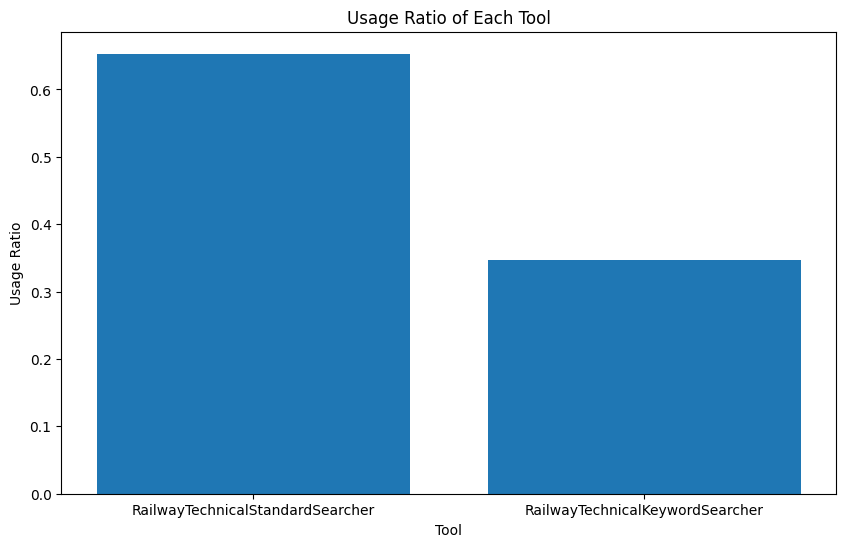

In [15]:
# ツール使用状況の可視化
current_tool_usage_counts = tool_usage_tracker.get_counts()
if len(current_tool_usage_counts) > 0:
    plot_tools_count(current_tool_usage_counts)